# **I- Category Detection:**

# 1) Importing data from Kaggle

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d rmisra/news-category-dataset
!unzip news-category-dataset.zip

# 2) Data Understanding:

In [ ]:
# Importing Libraries

!pip install bert-for-tf2
!pip install transformers
import pandas as pd
import pickle
import random
import gzip
import gensim 
import logging
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import keras
import bert
import math
import re as re
import transformers
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Reading dataset

all_data = pd.read_json('News_Category_Dataset_v2.json', lines = True)
all_data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
print(set(all_data['category']))
print('Number of categories: ',len(set(all_data['category'])))

{'ARTS & CULTURE', 'QUEER VOICES', 'DIVORCE', 'MEDIA', 'FIFTY', 'ENTERTAINMENT', 'FOOD & DRINK', 'WOMEN', 'CRIME', 'MONEY', 'PARENTING', 'TECH', 'POLITICS', 'ARTS', 'WORLD NEWS', 'RELIGION', 'BUSINESS', 'COMEDY', 'WORLDPOST', 'STYLE', 'SCIENCE', 'TASTE', 'ENVIRONMENT', 'STYLE & BEAUTY', 'COLLEGE', 'LATINO VOICES', 'SPORTS', 'WEDDINGS', 'BLACK VOICES', 'WEIRD NEWS', 'PARENTS', 'TRAVEL', 'GREEN', 'WELLNESS', 'EDUCATION', 'GOOD NEWS', 'CULTURE & ARTS', 'THE WORLDPOST', 'HOME & LIVING', 'HEALTHY LIVING', 'IMPACT'}
Number of categories:  41


In [7]:
# I choosed 6 categories from 41 in the above dataset
data = all_data[(all_data['category']=='CRIME') | (all_data['category']=='POLITICS') | (all_data['category']=='SPORTS') | (all_data['category']=='BUSINESS') | (all_data['category']=='SCIENCE') | (all_data['category']=='TECH')].copy()
data.index = [i for i in range(data.shape[0])]

In [8]:
# Display the shape of data
data.shape

(51225, 6)

In [9]:
# Display the column names
data.columns

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [10]:
# Display the type of data
data.dtypes

category                     object
headline                     object
authors                      object
link                         object
short_description            object
date                 datetime64[ns]
dtype: object

In [11]:
# Display the number of missing values for each column
data.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

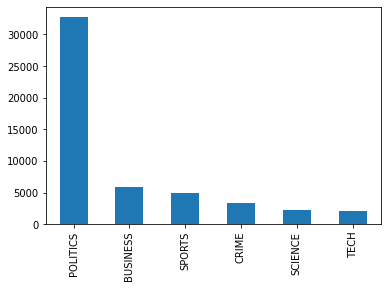

In [12]:
# Display the distribution of data
data['category'].value_counts().plot.bar()

In [13]:
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,2018-05-26
2,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,2018-05-26
3,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26
4,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,2018-05-26


# 3) Data Preparation:

In [14]:
# Concatenate headline and short_description

data['information'] = data[['headline', 'short_description']].apply(lambda x: ' '.join(x), axis=1)

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data["categoryEncoded"] = label_encoder.fit_transform(data['category'])

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text,stem=False):
    # Lower case
    text = text.lower().strip()
    # Removing html tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Removing stop words
    text =  [word.lower() for word in text.split() if word not in stopwords.words('english')]
    # lemmatize data
    stemmer = WordNetLemmatizer()
    text = [stemmer.lemmatize(word) for word in text]
    return ' '.join(text)

In [17]:
# preprocess the text data
L = []
sentences = list(data['information'])
for sen in sentences:
    L.append(preprocess_text(sen))

# save the result
open_file = open("text_preprocessed", "wb")
pickle.dump(L, open_file)
open_file.close()

In [18]:
# text cleaned

data['text'] = L

In [ ]:
# Creation of the Tokenizer

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [20]:
# Tokenizing Data

def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

tokenized_data = [tokenize_reviews(d) for d in data['text']]

In [21]:
# Build an X y list and shuffle the data

data_list = [[x,data['categoryEncoded'][i]] for i, x in enumerate(tokenized_data)]
random.shuffle(data_list)
shuffled_data = [(x[0], x[1]) for x in data_list]

# 4) Modeling:

### a) CNN:

In [22]:
# convert the sorted dataset into a TensorFlow 2.0-compliant input dataset shape.
processed_dataset = tf.data.Dataset.from_generator(lambda: shuffled_data, output_types=(tf.int32, tf.int32))

#  pad the dataset for each batch
categories = 6
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

# We divide the dataset into test and training sets
TOTAL_BATCHES = math.ceil(len(shuffled_data) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [23]:
# Creating the model

class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [27]:
# Defining hyper parameters
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = categories
DROPOUT_RATE = 0.2
NB_EPOCHS = 2

In [28]:
# We create an object of the TEXT_MODEL class and pass the hyper paramters values 
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [29]:
# Complie the model
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [30]:
# Training
text_model.fit(train_data, batch_size=BATCH_SIZE,epochs=NB_EPOCHS, validation_data=(test_data))

Epoch 1/2
1441/1441 [==============================] - 113s 77ms/step - loss: 0.7275 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.3673 - val_sparse_categorical_accuracy: 0.8699
Epoch 2/2
1441/1441 [==============================] - 110s 76ms/step - loss: 0.2713 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.4822 - val_sparse_categorical_accuracy: 0.8629


In [37]:
# Evaluate the model on test data

results = text_model.evaluate(test_data)

160/160 [==============================] - 3s 18ms/step - loss: 0.4822 - sparse_categorical_accuracy: 0.8629


### b) SVM:

In [106]:
# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorize = TfidfVectorizer()
tf_idf_text = vectorize.fit(data['text'])
vector1 = tf_idf_text.transform(data['text'])

In [32]:
# Split the data into train and test.

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(vector1, data['category'], test_size=0.33)

In [33]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score ,confusion_matrix

SVM = LinearSVC()
SVM.fit(X_train,Y_train)
Y_predict = SVM.predict(X_test)
accuracy_SVM = accuracy_score(Y_test,Y_predict)*100

### c) Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_Regression = LogisticRegression()
logistic_Regression.fit(X_train,Y_train)
Y_predict = logistic_Regression.predict(X_test)
accuracy_logistic_Regression = accuracy_score(Y_test,Y_predict)*100

### d) Naive Bayes:

In [35]:
from sklearn.naive_bayes import MultinomialNB

NaiveBayes = MultinomialNB(alpha=0.1)
NaiveBayes.fit(X_train,Y_train)
Y_predict = NaiveBayes.predict(X_test)
accuracy_NaiveBayes = accuracy_score(Y_test,Y_predict)*100

# 5) Evaluation:

In [78]:
# Diplaying accuracy for each model

print("Accuracy\n")
print("CNN + Bert: ", format(results[1]*100, '.2f'),"%")
print("SVM: ",format(accuracy_SVM, '.2f'),"%")
print("Logistic Regression: ",format(accuracy_logistic_Regression, '.2f'),"%")
print("Naive Bayes: ",format(accuracy_NaiveBayes, '.2f'),"%")

Accuracy

CNN + Bert:  86.29 %
SVM:  86.80 %
Logistic Regression:  85.48 %
Naive Bayes:  83.63 %


In [79]:
# List of categories

catego = ['BUSINESS', 'CRIME', 'POLITICS', 'SCIENCE', 'SPORTS', 'TECH']

In [113]:
# test text

text = "jhon killed his father and mother and escaped"
text = "all the scientist are trying to make new vaccine against the covid 19"
text = "Joe Biden is the new president of US"
t = preprocess_text(text)

In [114]:
prediction = text_model.predict([tokenize_reviews(t)])
print("CNN + Bert: ",catego[np.argmax(prediction)])
print("SVM: ",SVM.predict(tf_idf_text.transform([t])))
print("Logistic Regression: ",logistic_Regression.predict(tf_idf_text.transform([t])))
print("Naive Bayes: ",NaiveBayes.predict(tf_idf_text.transform([t])))

CNN + Bert:  POLITICS
SVM:  ['POLITICS']
Logistic Regression:  ['POLITICS']
Naive Bayes:  ['POLITICS']


In [ ]:
# saving the model

text_model.save('model',save_format='tf')
!apt-get install rar
!zip -r "model.zip" "/content/model"

# **II- Sentiment Analysis:**

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [61]:
data['scores'] = data['text'].apply(lambda text: sid.polarity_scores(text))
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['sentiment'] = data['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [62]:
data.head()

,category,headline,authors,link,short_description,date,information,categoryEncoded,text,scores,compound,sentiment
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,1,mass shooting texas last week tv left husband ...,"{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'comp...",-0.6705,neg
1,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,2018-05-26,Trump's Crackdown On Immigrant Parents Puts Mo...,2,trump crackdown immigrant parent put kid alrea...,"{'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'comp...",-0.4019,neg
2,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,2,trump son concerned fbi obtained wiretap putin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26,Edward Snowden: There's No One Trump Loves Mor...,2,edward snowden one trump love vladimir putin c...,"{'neg': 0.08, 'neu': 0.682, 'pos': 0.239, 'com...",0.5859,pos
4,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,2018-05-26,Booyah: Obama Photographer Hilariously Trolls ...,2,booyah obama photographer hilariously troll tr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos


# **III- Topic Modeling:**

# 1) Non-negative Matrix Factorization (NMF):

In [63]:
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=categories,random_state=42)
nmf_model.fit(vector1)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [65]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tf_idf_text.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['police', 'american', 'woman', 'time', 'say', 'people', 'one', 'state', 'year', 'new']


THE TOP 10 WORDS FOR TOPIC #1
['day', 'start', 'short', 'welcome', 'wrap', 'news', 'morning', 'newsbrief', 'rise', 'huffpost']


THE TOP 10 WORDS FOR TOPIC #2
['think', 'election', 'voter', 'russia', 'said', 'say', 'campaign', 'president', 'donald', 'trump']


THE TOP 10 WORDS FOR TOPIC #3
['poll', 'presidential', 'debate', 'email', 'campaign', 'democratic', 'bernie', 'sander', 'hillary', 'clinton']


THE TOP 10 WORDS FOR TOPIC #4
['tax', 'party', 'obamacare', 'democrat', 'senate', 'bill', 'care', 'health', 'gop', 'republican']


THE TOP 10 WORDS FOR TOPIC #5
['climate', 'congress', 'said', 'say', 'administration', 'barack', 'president', 'white', 'house', 'obama']




In [66]:
topic_results = nmf_model.transform(vector1)
topic_results.argmax(axis=1)

data['NMF'] = topic_results.argmax(axis=1)

In [67]:
data.head()

,category,headline,authors,link,short_description,date,information,categoryEncoded,text,scores,compound,sentiment,NMF
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,1,mass shooting texas last week tv left husband ...,"{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'comp...",-0.6705,neg,0
1,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,2018-05-26,Trump's Crackdown On Immigrant Parents Puts Mo...,2,trump crackdown immigrant parent put kid alrea...,"{'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'comp...",-0.4019,neg,2
2,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,2,trump son concerned fbi obtained wiretap putin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,2
3,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26,Edward Snowden: There's No One Trump Loves Mor...,2,edward snowden one trump love vladimir putin c...,"{'neg': 0.08, 'neu': 0.682, 'pos': 0.239, 'com...",0.5859,pos,2
4,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,2018-05-26,Booyah: Obama Photographer Hilariously Trolls ...,2,booyah obama photographer hilariously troll tr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,5


# 2) Latent Dirichlet Allocation (LDA):

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(data['text'])

In [69]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=categories,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [70]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['team', 'know', 'player', 'huffpost', 'rise', 'time', 'day', 'new', 'game', 'world']


THE TOP 10 WORDS FOR TOPIC #1
['government', 'federal', 'people', 'judge', 'supreme', 'law', 'obama', 'state', 'right', 'court']


THE TOP 10 WORDS FOR TOPIC #2
['like', 'wall', 'time', 'people', 'job', 'tax', 'new', 'year', 'business', 'company']


THE TOP 10 WORDS FOR TOPIC #3
['russia', 'paul', 'obama', 'said', 'house', 'white', 'say', 'president', 'donald', 'trump']


THE TOP 10 WORDS FOR TOPIC #4
['party', 'democrat', 'candidate', 'sander', 'health', 'hillary', 'gop', 'trump', 'republican', 'clinton']


THE TOP 10 WORDS FOR TOPIC #5
['school', 'said', 'old', 'new', 'shooting', 'say', 'man', 'gun', 'year', 'police']




In [71]:
topic_results = LDA.transform(dtm)
topic_results.argmax(axis=1)
data['LDA'] = topic_results.argmax(axis=1)

In [72]:
data.head()

,category,headline,authors,link,short_description,date,information,categoryEncoded,text,scores,compound,sentiment,NMF,LDA
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,1,mass shooting texas last week tv left husband ...,"{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'comp...",-0.6705,neg,0,5
1,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,2018-05-26,Trump's Crackdown On Immigrant Parents Puts Mo...,2,trump crackdown immigrant parent put kid alrea...,"{'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'comp...",-0.4019,neg,2,5
2,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,2,trump son concerned fbi obtained wiretap putin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,2,3
3,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26,Edward Snowden: There's No One Trump Loves Mor...,2,edward snowden one trump love vladimir putin c...,"{'neg': 0.08, 'neu': 0.682, 'pos': 0.239, 'com...",0.5859,pos,2,3
4,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,2018-05-26,Booyah: Obama Photographer Hilariously Trolls ...,2,booyah obama photographer hilariously troll tr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,5,3
